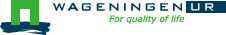




# An Jupyter notebook demonstrating the use of PCSE/WOFOST with the Ensemble Kalman Filter (EnKF)

# Taking non-observable states into the state vector

*Allard de Wit, Wageningen Environmental Research, 
March 2022 (allard.dewit@wur.nl)*

This Jupyter notebook is an extension of the other notebook on the EnKF (number `08a`). It demonstrates how non-observable states can be added to the state vector and how they can be updated using the observed states. To make the notebook more compact most of the descriptions have been taken out, so please look at the `08a` notebook for the introduction.

**Note that the major changes compares with the `08a` notebook are in section 2.4.5.**

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. PCSE and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. `pandas` for processing and storing WOFOST output;
  3. `numpy` for array processing;
  4. `matplotlib` for plotting.

# 1. Introduction

This example will demonstrate how to apply the Ensemble Kalman filter for assimilating satellite observations of leaf area index (LAI) and use those estimates not only to update LAI, but also to update  weight stems (WST) and weight storage (WSO). The weight leaves (WLV) is also adjusted but this adjustment goes through LAI.

# 2. Applying the EnKF with PCSE/WOFOST

## 2.1 importing the relevant modules

First the required modules need to be imported including pandas, numpy, matplotlib and the WOFOST model from PCSE.

In [1]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:01:37) [MSC v.1935 64 bit (AMD64)] 
PCSE version: 5.5.5


## 2.2 The LAI observations
For this exercise, we assume that we have observations on five dates of leaf area index ("LAI"), as in the previous notebook.

In [2]:
variables_for_DA = ["LAI", "WST", "WSO"]
observed_states = ["LAI"]
dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]
observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
std_lai = observed_lai * 0.1 # Std. devation is estimated as 10% of observed value
observations_for_DA = []
# Pack them into a convenient format
observations_for_DA = [(d, {"LAI": (lai, errlai)}) for d, lai, errlai, in zip(dates_of_observation, observed_lai, std_lai)]

## 2.3. Setting up the ensemble
Setting up the ensemble is similar to the previous notebook.

In [3]:
ensemble_size = 50
np.random.seed(10000)

### 2.3.2 Defining variability in the ensemble
As in the previous notebook, 4 parameters/initial conditions are drawn from random distributions.

In [4]:
from dataproviders import parameters, agromanagement, weather
# A container for the parameters that we will override
override_parameters = {}
#Initial conditions
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03 ,(ensemble_size))

## 2.3.3 Initializing the ensemble


In [5]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

## 2.4. Implementing the data assimilation itself
### 2.4.1 Move the ensemble forward in time until the first analysis step
First we take the first observation from the set of observations. Next, we will instruct each ensemble member to move forward in time (simulate the crop) up till the date where the first observation is available. The latter is done with the `run_till()` function on each member.

In [30]:
day, obs = observations_for_DA.pop(0)
for member in ensemble:
    member.run_till(day)
print("Ensemble now at day %s" % member.day)
print("%s observations left!" % len(observations_for_DA))

Ensemble now at day 2000-05-01
0 observations left!


All ensemble members should now have reached the day where we have an observations:

### 2.4.2 Retrieve the states from the ensemble and compute covariance


In [31]:
collected_states = []
for member in ensemble:
    t = {}
    for state in variables_for_DA:
        t[state] = member.get_variable(state)
    collected_states.append(t)
df_A = pd.DataFrame(collected_states)
A = np.matrix(df_A).T
P_e = np.matrix(df_A.cov())

### 2.4.4. Calculate perturbed observations and their mean and covariance

In [32]:
perturbed_obs = []
for state in observed_states:
    (value, std) = obs[state]
    d = np.random.normal(value, std, (ensemble_size))
    perturbed_obs.append(d)
df_perturbed_obs = pd.DataFrame(perturbed_obs).T
df_perturbed_obs.columns = observed_states
D = np.matrix(df_perturbed_obs).T  # Perturbed observations
R_e = np.matrix(df_perturbed_obs.cov())  # Covariance

### 2.4.5 Apply the Kalman filter equations
In order to take into account that there are more states than observations in the state vector, a modification is required with regard to the $H$ operator in the Kalman filter equations. This operator converts the model states into an observation, or as often written in literature, it converts *state space* into *observation space*. It must be defined as a matrix of shape `(n_observations, n_states)` which in our case is a `(1,3)` matrix because we have one observation (LAI) and three states (LAI, WST, WSO). The values of the $H$ operator become `[1.0, 0, 0]` which can be interpreted as follows:

$$lai_{observed} = 1.0 \cdot LAI_{simulated} + 0.0 \cdot WST_{simulated} + 0.0 \cdot WSO_{simulated} $$

So in this case the $H$ matrix directly maps the simulated LAI to the observed LAI and there is no contribution of weight stems and storage organs on LAI. Nevertheless, because WST and WSO are part of the state vector they are taken into account through the covariance matrix. So if *linear* correlations between LAI and WST/WSO exist, an observation of LAI can be used to update WST/WSO.

Also note that the $H$ operator can be used to map any linear combination of model states towards observation space. However, since for crop models, many relationships between observations and state variables are not linear this will not work and the $H$ operator is only used to map the states onto the observations.

In [33]:
H = np.matrix([1.,0.,0.])
K1 = P_e * (H.T)
K2 = (H * P_e) * H.T
K = K1 * ((K2 + R_e).I)

In [34]:
# Here we compute the analysed states
Aa = A + K * (D - (H * A))
df_Aa = pd.DataFrame(Aa.T, columns=variables_for_DA)

### 2.4.6 Update the ensemble to reflect the new state
We have computed the new states for each ensemble member which are collected in the dataframe `df_Aa`. We now need to update each WOFOST ensemble member to update its internal state to the value in `df_Aa`. This update is done with the `set_variable(<varname>, <value>)` method that is available on each WOFOST object. 

In [35]:
for member, new_states in zip(ensemble, df_Aa.itertuples()):
    member.set_variable("LAI", new_states.LAI)
    member.set_variable("WST", new_states.WST)
    member.set_variable("WSO", new_states.WSO)

### 2.4.7 Repeat steps 2.4.1 to 2.4.6 for the next analysis step (observation)

We now need to repeat the above steps for each observation available and until the cell under 2.4.1 reports `0 observations left!`

### 4.8 Run all the ensemble members until the end of the growing season

Finally, we can run the WOFOST ensemble until the end of the growing season using the `run_till_terminate()` call.

In [36]:
for member in ensemble:
    member.run_till_terminate()

# 3. Visualizing output from the ensemble with the EnKF
## 3.1 Retrieve output from the ensemble

First we retrieve the simulated output from each ensemble member and convert it into a dataframe.

In [37]:
results = [pd.DataFrame(member.get_output()).set_index("day") for member in ensemble]

## 3.2 Visualize ensemble with EnKF

Now we plot the simulated output for the variables LAI, WST, WSO and TAGP for each ensemble member. Note that the TAGP represents the sum of biomass of leaves, stems and storage organs. 


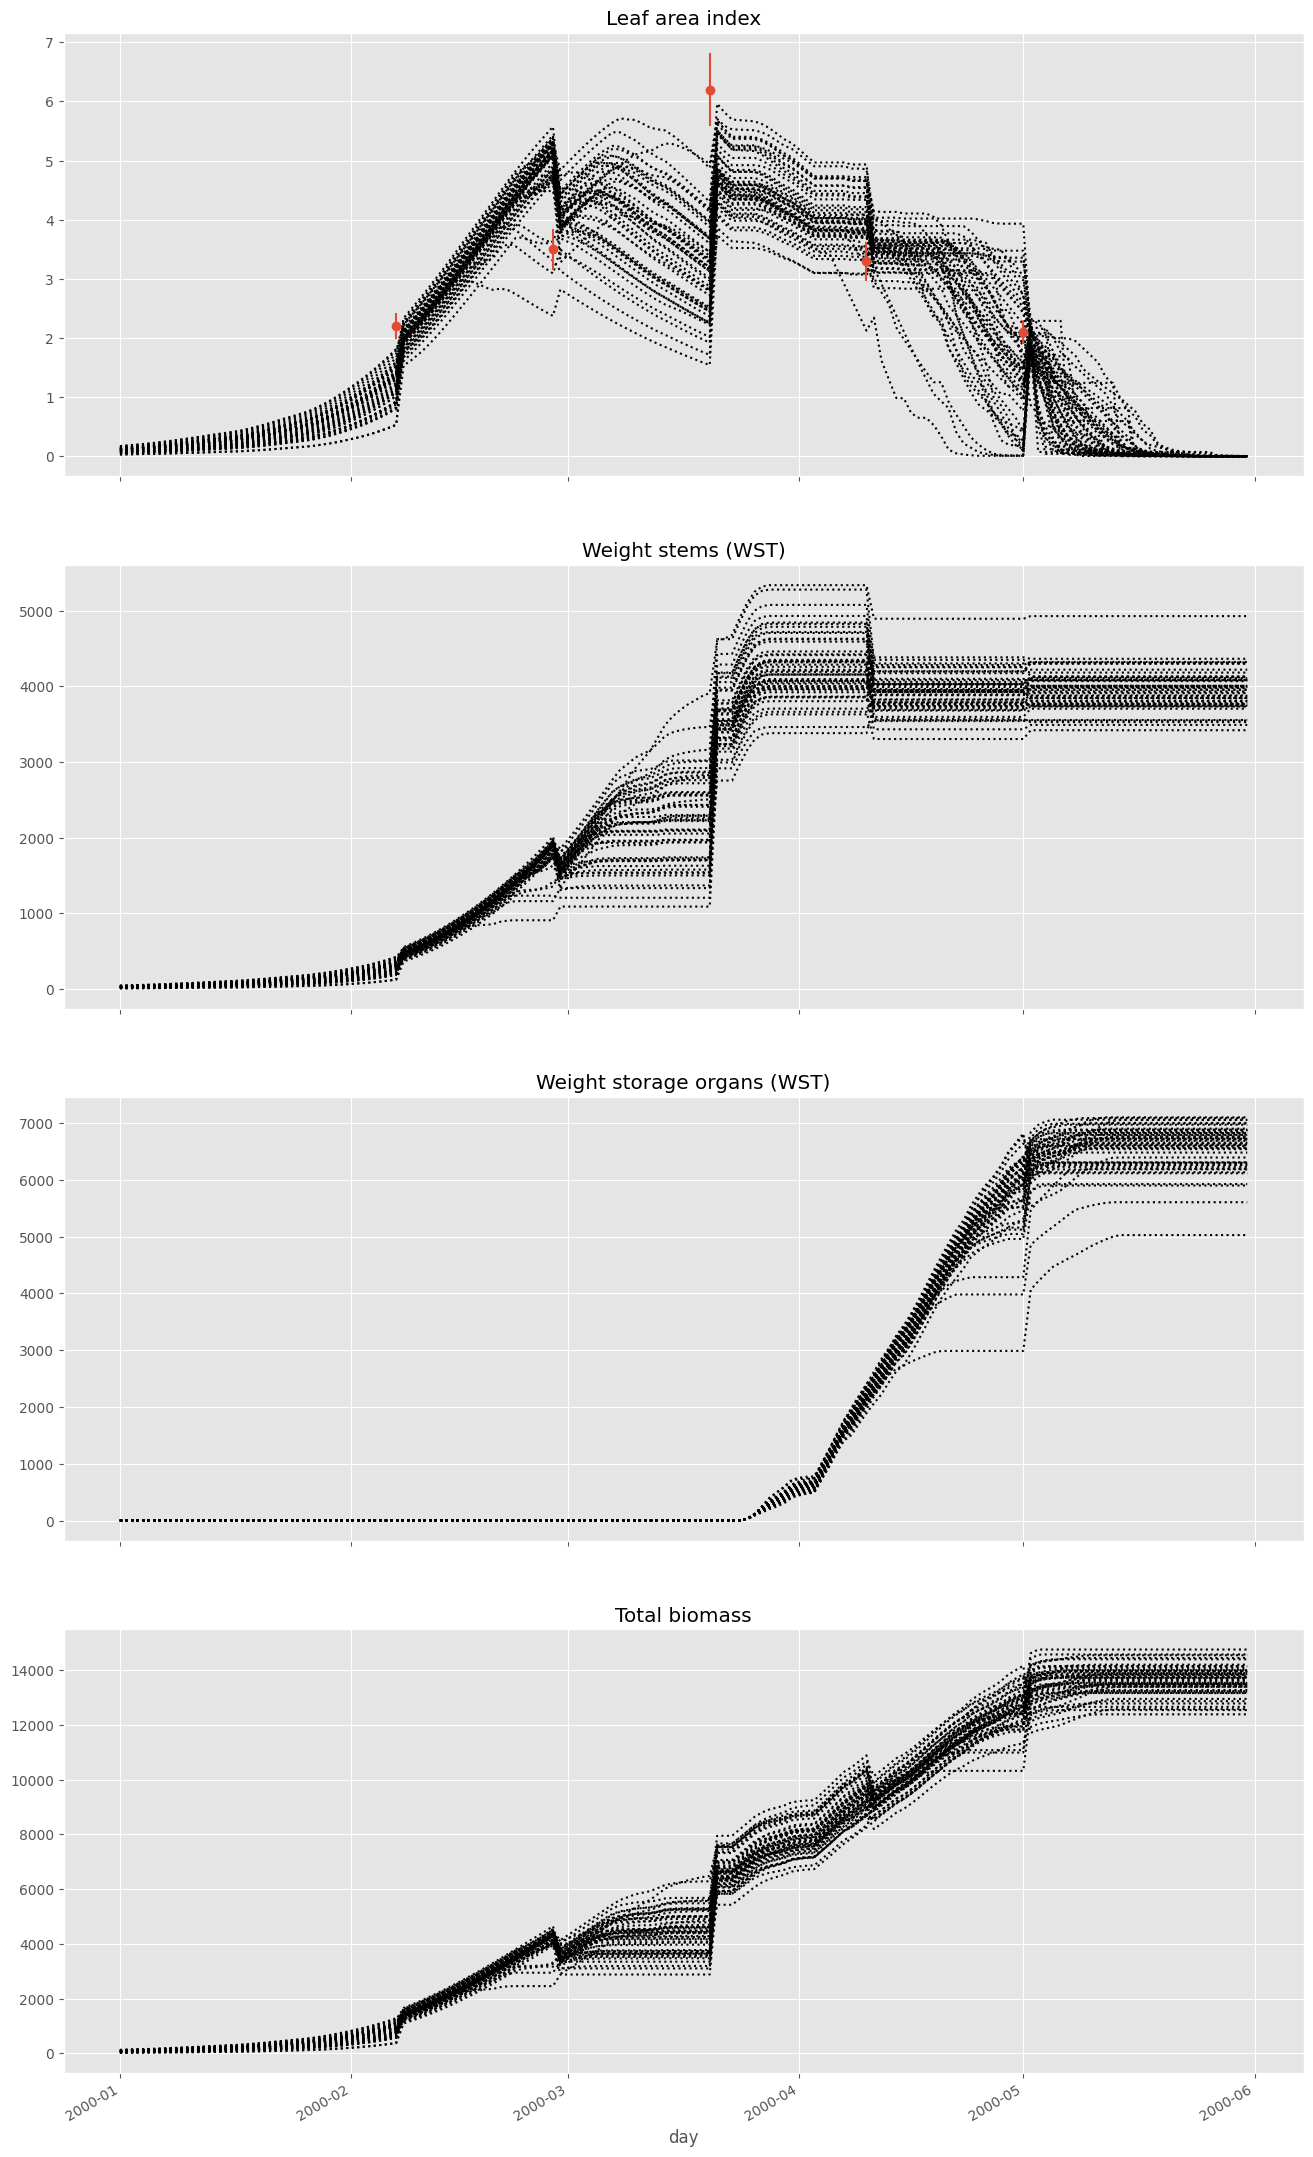

In [38]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16,30), sharex=True)
for member_df in results:
    member_df["LAI"].plot(style="k:", ax=axes[0])
    member_df["TWST"].plot(style="k:", ax=axes[1])
    member_df["TWSO"].plot(style="k:", ax=axes[2])
    member_df["TAGP"].plot(style="k:", ax=axes[3])
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Weight stems (WST)")
axes[2].set_title("Weight storage organs (WST)")
axes[3].set_title("Total biomass")
fig.autofmt_xdate()

The graphs above clearly demonstrate the impact of the observations on the simulated values. At each time step where an observation of LAI is available, the ensemble mean is adjusted towards the observation and the uncertainty in the LAI ensemble is strongly reduced. Moreover, the stem biomass is clearly adjusted by assimilating LAI, this means that clear correlations exist between stem biomass and LAI, e.g. high LAI corresponds with high stem biomass and vice versa. Also the biomass storage organs is adjusted but to a lesser extend probably because the strength of the correlations fade as the growing season progresses. This is also visible in the stem biomass: the last EnKF update is relatively small. Finally, total biomass is computed as the sum of leaves, stems and storage organs and it therefore clearly demonstrates the adjustments made by the EnKF on all biomass components of the model.

# 4. Doing everything in one loop

In practice, it can be cumbersome to manually iterate through a notebook multiple times.
Instead, it is much more convenient to apply the data assimilation in a single loop that runs until a defined end point, such as the current date or a desired state.

## 4.1 Setup
For convenience, we first set up the data and model ensemble in the same way as before.

In [39]:
# Setting up the data
variables_for_DA = ["LAI", "WST", "WSO"]
observed_states = ["LAI"]
dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]
observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
std_lai = observed_lai * 0.1 # Std. devation is estimated as 10% of observed value
observations_for_DA = []
# Pack them into a convenient format
observations_for_DA = [(d, {"LAI": (lai, errlai)}) for d, lai, errlai, in zip(dates_of_observation, observed_lai, std_lai)]

# Setting up the ensemble
ensemble_size = 50
np.random.seed(10000)
override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3, (ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03, (ensemble_size))

# Initializing the ensemble
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

Next, we define some functions that perform the different steps, for ease of use in the loop.

In [40]:
def move_ensemble_forwards(ensemble, observations):
    # Note that this edits 'observations' in place
    day, obs = observations.pop(0)
    for member in ensemble:
        member.run_till(day)
    print("Ensemble now at day %s" % member.day)
    print("%s observations left!" % len(observations))
    return day, obs

def retrieve_states_from_ensemble(ensemble, variables):
    collected_states = []
    for member in ensemble:
        t = {}
        for state in variables:
            t[state] = member.get_variable(state)
        collected_states.append(t)
    df_A = pd.DataFrame(collected_states)
    A = np.matrix(df_A).T
    P_e = np.matrix(df_A.cov())
    return A, P_e

def compute_perturbed_observations(observation_single, variables, ensemble_size):
    perturbed_obs = []
    for state in variables:
        (value, std) = observation_single[state]
        d = np.random.normal(value, std, (ensemble_size))
        perturbed_obs.append(d)
    df_perturbed_obs = pd.DataFrame(perturbed_obs).T
    df_perturbed_obs.columns = variables
    D = np.matrix(df_perturbed_obs).T
    R_e = np.matrix(df_perturbed_obs.cov())
    return D, R_e

def compute_Kalman_gain(observation_single, P_e, R_e):
    H = np.matrix([1.,0.,0.])
    K1 = P_e * (H.T)
    K2 = (H * P_e) * H.T
    K = K1 * ((K2 + R_e).I)
    return K

def compute_analysed_states(A, D, variables):
    Aa = A + K * (D - (H * A))
    df_Aa = pd.DataFrame(Aa.T, columns=variables)
    return df_Aa

def update_ensemble(ensemble, analysed_states):
    for member, new_states in zip(ensemble, analysed_states.itertuples()):
        member.set_variable("LAI", new_states.LAI)
        member.set_variable("WST", new_states.WST)
        member.set_variable("WSO", new_states.WSO)

## 4.2 Loop
We can now run everything in one loop until all observations have been assimilated into the ensemble.

In [41]:
# Run the main loop as long as there are new observations to add
while len(observations_for_DA) > 0:
    day, obs = move_ensemble_forwards(ensemble, observations_for_DA)
    A, P_e = retrieve_states_from_ensemble(ensemble, variables_for_DA)
    D, R_e = compute_perturbed_observations(obs, observed_states, ensemble_size)
    K = compute_Kalman_gain(obs, P_e, R_e)
    analysed_states = compute_analysed_states(A, D, variables_for_DA)
    update_ensemble(ensemble, analysed_states)

# Finish the ensemble
for member in ensemble:
    member.run_till_terminate()
print("Ensemble finished!")

Ensemble now at day 2000-02-07
4 observations left!
Ensemble now at day 2000-02-28
3 observations left!
Ensemble now at day 2000-03-20
2 observations left!
Ensemble now at day 2000-04-10
1 observations left!
Ensemble now at day 2000-05-01
0 observations left!
Ensemble finished!


## 4.3 Results
Finally, we can retrieve the results from the ensemble and plot them, as we did before.

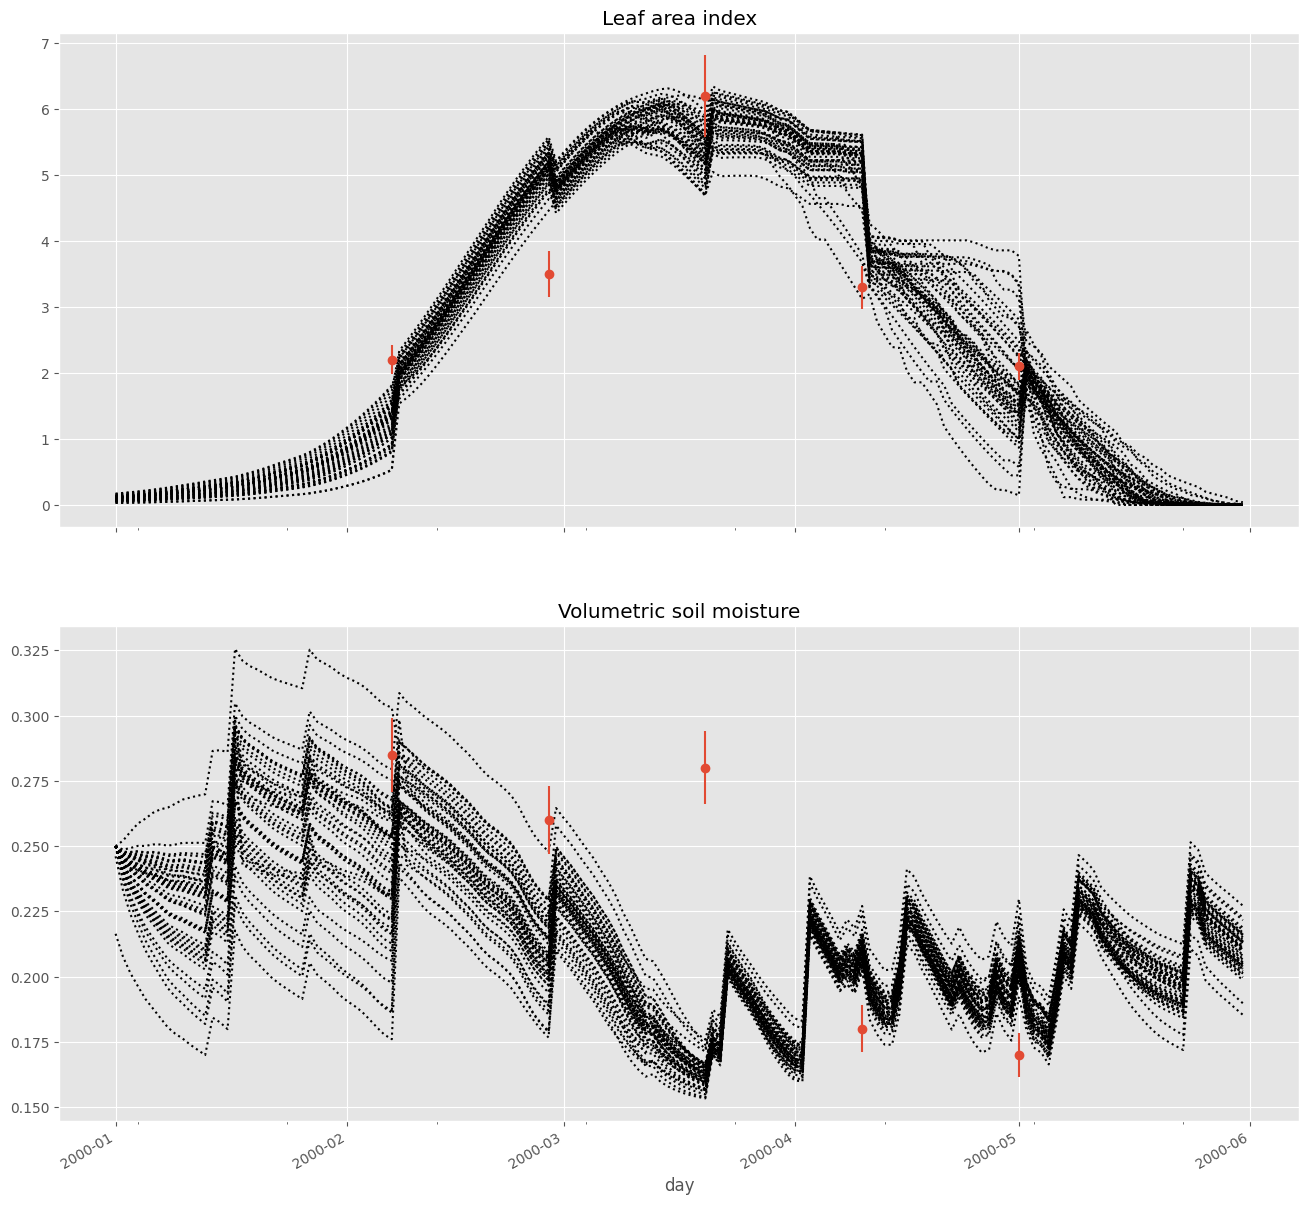

In [42]:
# Retrieve model results and put them in dataframes
results = [pd.DataFrame(member.get_output()).set_index("day") for member in ensemble]

# Plot the results
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16,30), sharex=True)
for member_df in results:
    member_df["LAI"].plot(style="k:", ax=axes[0])
    member_df["TWST"].plot(style="k:", ax=axes[1])
    member_df["TWSO"].plot(style="k:", ax=axes[2])
    member_df["TAGP"].plot(style="k:", ax=axes[3])
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Weight stems (WST)")
axes[2].set_title("Weight storage organs (WST)")
axes[3].set_title("Total biomass")
fig.autofmt_xdate()